In [1]:
from numba import cuda
major, minor = cuda.get_current_device().compute_capability
print(f'GPU compute capability: {major}.{minor}')

GPU compute capability: 7.5


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [2]:
# Đoạn code Python để hiển thị file ảnh pnm ở notebook
# Ví dụ để hiển thị file "img.pnm", ở dòng cuối của code cell
# bạn gõ (không cần dấu ! đằng trước): show_pnm('img.pnm')
# LƯU Ý: bạn phải chạy cell này một lần thì mới gọi được hàm show_pnm
from PIL import Image
import numpy as np
def show_pnm(file_name):
  with open(file_name, 'r') as f:
    vals = f.read().split()
  w = int(vals[1])
  h = int(vals[2])
  if vals[0] == 'P2': # Grayscale
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w))
  elif vals[0] == 'P3': # RGB
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w, 3))
  else:
    return None
  print("Image size (width x height): {} x {}".format(w, h))
  return Image.fromarray(pixels)

# Đoạn code Python để hiển thị file chứa ma trận ở notebook
# (một dòng của ma trận ứng với một dòng trong file, 
# các phần tử trên mỗi dòng được cách nhau bởi khoảng trắng) 
# Ví dụ để hiển thị file "pixel_importance.txt", ở dòng cuối của code cell
# bạn gõ: show_matrix('pixel_important.txt')
def show_matrix(matrix_file):
  m = np.loadtxt(matrix_file)
  m = m + m.min()
  m = m / m.max()
  m = m * 255
  m = m.astype(np.uint8)
  return Image.fromarray(m)

# Đồ án cuối kỳ

Song song hóa và tối ưu hóa một ứng dụng

### Thành viên nhóm 

  *  21424088 - Huỳnh Văn Thái
  *  21424069 - Nguyễn Bá Việt
  *  21424032 - Võ Công Minh


### Tên dự án

Song song hóa và tối ưu hóa ứng dụng Thay đổi kích thước ảnh bằng thuật toán Seam carving.

### Vấn đề

Để triển khai Thuật toán Seam Carving xử lý hình ảnh bằng cách sử dụng phương pháp tiếp cận tuần tự và song song. Việc triển khai tuần tự sẽ được thực hiện trên host CPU (Bộ xử lý trung tâm) và việc triển khai song song sẽ được thực hiện trên GPU NVidia hỗ trợ CUDA (Kiến trúc thiết bị điện toán hợp nhất).

_Mục đích chính của phần trình diễn này là cho thấy sự khác biệt giữa tốc độ tính toán của CPU và GPU._

# I. Giới thiệu

### 1. Seam Carving là gì?

Theo Wikipedia :

> **Seam carving is an algorithm for image resizing**, developed by Shai Avidan, of Mitsubishi
> Electric Research Laboratories (MERL), and Ariel Shamir, of the Interdisciplinary Center and MERL. It
> functions by establishing a number of seams (paths of least importance) in an image and **automatically
> removes seams to reduce image size or inserts seams to extend it.** Seam carving also allows manually
> defining areas in which pixels may not be modified, and **features the ability to remove whole objects from
> photographs.**
>
> _The purpose of the algorithm is to display images without distortion on various media (cell
> phones, PDAs) using document standards, like HTML, that already support dynamic changes in page
> layout and text, but not images._

* *Seam carving là một thuật toán để thay đổi kích thước hình ảnh, tự động loại bỏ các đường seam để giảm kích thước hình ảnh hoặc chèn các seam để mở rộng hình ảnh*

* *Hãy xem [video giải thích](https://youtu.be/6NcIJXTlugc) này để hiểu thêm chi tiết.*

![Sample gif](https://drive.google.com/uc?id=1pJxGOdxTyCQQKM0DWfgSeEbPNelBurR4)

### 2. Một Seam là gì?

Theo Wikipedia :

>Seams can be either vertical or horizontal. **A vertical seam is a path of connected pixels from top
to bottom in an image with one pixel in each row.** A horizontal seam is similar with the exception of the
connection being from left to right. The importance/energy function values a pixel by measuring its
contrast with its neighbor pixels.

* *Một seam: một tập các pixel, mỗi dòng một pixel, pixel của dòng r & dòng r+1 được kết nối với nhau.*



## II. Nội dung
### 1. Mô tả dự án

- Input: một ảnh đầu vào RGB `in.pnm`

![image](https://drive.google.com/uc?id=154_BR4vkQW6cnE38xxpzF8VAu9p9D_pd)

- Output: một ảnh đầu ra RGB `out.pnm` được thay đổi kích thước **mà không làm biến dạng các đối tượng quan trọng** (tấm ảnh được thu hẹp chiều rộng lại).

![image](https://drive.google.com/uc?id=1KI3J_aa9SNJDOAAoANj-PeuXDwdp_LFu)

- File khung chương trình `seamcarving_v1.cu`.

### 2. Ý nghĩa thực tế:

  - Ứng dụng seam carving được sử dụng để thay đổi kích thước hình ảnh mà không làm biến đổi hoặc làm thay đổi nội dung của hình ảnh ban đầu. Thay vì cắt hoặc co giãn hình ảnh, seam carving tìm kiếm các đường seam (dòng điểm ảnh) ít quan trọng và xóa chúng hoặc chèn thêm chúng, điều này cho phép thay đổi kích thước hình ảnh một cách không đáng kể mà vẫn giữ được các đặc điểm quan trọng của hình ảnh ban đầu.

  - Ứng dụng của seam carving là rất đa dạng, từ việc tạo ra các ảnh thu nhỏ hoặc phóng to cho các trang web hay ứng dụng di động, đến việc chỉnh sửa kích thước hình ảnh trong các dự án thiết kế đồ họa và phim ảnh. Nó cũng có thể được sử dụng để loại bỏ các đối tượng không mong muốn trong hình ảnh.

- Ứng dụng này có cần tăng tốc không?

  - Tùy thuộc vào kích thước và độ phức tạp của hình ảnh, quá trình seam carving có thể mất nhiều thời gian để hoàn thành. Vì vậy, Việc tăng tốc xử lý là cần thiết để đảm bảo rằng quá trình seam carving diễn ra nhanh chóng và hiệu quả.

  - Phương pháp tối ưu hóa được sử dụng để cải thiện tốc độ xử lý trong seam carving được đề xuất trong dự án này : **Sử dụng phần cứng tăng tốc như GPU để giảm thời gian xử lý**.

## III. Cài đặt tuần tự 


#### 1. Thiết kế

Thực hiện tuần từ qua các bước:

- **Bước 1. Khởi tạo và chuẩn bị dữ liệu:** Hàm khởi tạo và chuẩn bị các biến và mảng cần thiết cho việc Seam Carving, bao gồm mảng `inGrayscale` (lưu trữ ảnh xám đầu vào), mảng `energy` (lưu trữ mức độ quan trọng của mỗi pixel), ma trận `cost_v` (ma trận chi phí theo chiều dọc), mảng `importancy_h` (lưu trữ độ quan trọng theo chiều ngang), mảng `next_pixels_v` (lưu trữ chỉ số của Seam nhỏ nhất theo chiều dọc).

- **Bước 2. Chuyển đổi từ RGB sang Ảnh xám:** Bước này bao gồm chuyển đổi ảnh đầu vào từ không gian màu RGB sang ảnh xám. Mỗi giá trị RGB của pixel được chuyển đổi thành một giá trị xám duy nhất sử dụng công thức: 

> Y = 0.299R + 0.587G + 0.114B

Các giá trị pixel xám kết quả được lưu trữ trong mảng **inGrayscale**.

- **Bước 3. Tính toán mức độ quan trọng của từng pixel (dùng edge detection):** Trong bước này, mức độ quan trọng của mỗi pixel được tính toán dựa trên phát hiện biên. Các bộ lọc phát hiện biên (như **Sobel**) được áp dụng lên ảnh xám để tính toán đạo hàm theo chiều ngang và chiều dọc. Sau đó, mức độ quan trọng của mỗi pixel được tính toán bằng cách tổng hợp giá trị tuyệt đối của đạo hàm theo cả hai chiều. Kết quả được lưu trữ trong mảng `energy`.

> - Phát hiện cạnh theo chiều x (1): thực hiện convolution giữa ảnh grayscale với bộ lọc x-Sobel
>
> - Phát hiện cạnh theo chiều y (2): thực hiện convolution giữa ảnh grayscale với bộ lọc y-Sobel
>
> - Độ quan trọng của một pixel = |kết quả tương ứng của (1)| + |kết quả tương ứng của (2)|

![image](https://drive.google.com/uc?id=17_PF-IO4FK60l0BU5-05Lma43c0wUjah)

- **Bước 4. Tính ma trận chi phí theo chiều dọc:** Hàm tính toán ma trận chi phí theo chiều dọc của ảnh. Ma trận `cost_v` có cùng kích thước với ảnh xám và được khởi tạo bằng các giá trị mức độ quan trọng từ mảng `energy`. Tiếp theo, hàm duyệt qua từng hàng của ma trận `cost_v` từ trên xuống dưới và từ trái sang phải. Tại mỗi vị trí, chi phí của pixel được tính toán bằng cách xem xét đường đi có chi phí nhỏ nhất từ hàng bên dưới. Chi phí của mỗi pixel trong ma trận `cost_v` được cập nhật dựa trên chi phí tính toán và mức độ quan trọng của pixel tương ứng.

> giá trị `cost_v[i][j]` được tính như sau:
>
> Nếu j là cột đầu tiên, lấy giá trị bên phải của `cost_v[i-1][j]`
>
> Nếu j là cột cuối cùng, lấy giá trị bên trái của `cost_v[i-1][j]`
>
> Nếu j không nằm ở cột đầu tiên hoặc cuối cùng, lấy giá trị nhỏ nhất của hai phần tử bên trái và bên phải của nó trong hàng trên cùng của ma trận `cost_v` rồi cộng với `energy[i][j]`

![image](https://drive.google.com/uc?id=1UiGRuGpjnDOPHq70Ihcbf32b2W4h4O_U)

- **Bước 5. Tìm Seam nhỏ nhất:** Hàm tìm Seam nhỏ nhất bằng cách xác định đường đi có tổng chi phí nhỏ nhất từ đỉnh đến đáy của ma trận `cost_v`. Quá trình này được thực hiện theo các bước sau:

   - Đầu tiên, Seam nhỏ nhất được khởi tạo bằng cách tìm pixel có chi phí nhỏ nhất ở hàng cuối cùng của ma trận `cost_v`. Giá trị của pixel này được ghi lại vào mảng `next_pixels_v` tại vị trí tương ứng.

   - Tiếp theo, hàm duyệt qua từng hàng từ hàng cuối cùng trở lên hàng đầu tiên. Tại mỗi hàng, vị trí của Seam nhỏ nhất được xác định dựa trên giá trị của pixel ở hàng dưới. Hàm kiểm tra 3 vị trí trên hàng dưới, tương ứng với pixel trước, pixel hiện tại và pixel sau, và chọn vị trí có chi phí nhỏ nhất. Giá trị của pixel được chọn là giá trị tại vị trí đó trên hàng dưới cộng với mức độ quan trọng của pixel hiện tại. Vị trí của Seam nhỏ nhất được ghi lại vào mảng `next_pixels_v` tại vị trí tương ứng.

   - Sau khi hoàn thành vòng lặp, mảng `next_pixels_v` sẽ chứa chỉ số của Seam nhỏ nhất từ đỉnh đến đáy của ma trận `cost_v`.

  Quá trình tìm Seam nhỏ nhất này xảy ra theo chiều dọc, tạo ra một đường đi từ đỉnh đến đáy của ảnh.

![image](https://drive.google.com/uc?id=1x5xTymCw-v1rG7ULmftweBE1Po2NGL1h)

- **Bước 6. Xóa Seam nhỏ nhất:** Bước này nhằm loại bỏ Seam nhỏ nhất khỏi ảnh ban đầu. Quá trình này được thực hiện như sau:

  - Một vòng lặp duyệt qua từng hàng của ảnh được thực hiện. Trong mỗi hàng, ta duyệt qua từng pixel trên hàng đó.

  - Nếu pixel hiện tại nằm trước vị trí Seam nhỏ nhất (tức là có chỉ số nhỏ hơn), ta giữ nguyên giá trị của pixel đó và sao chép nó vào ảnh kết quả.

  - Ngược lại, nếu pixel hiện tại nằm sau vị trí Seam nhỏ nhất, ta dịch chuyển chỉ số của pixel hiện tại sang trái một vị trí (bỏ qua Seam nhỏ nhất). Sau đó, ta sao chép giá trị của pixel sau dịch chuyển vào ảnh kết quả.
  - Quá trình trên được lặp lại cho tất cả các hàng của ảnh.

  Sau khi hoàn thành vòng lặp, chiều rộng của ảnh sẽ được giảm đi một đơn vị do Seam nhỏ nhất đã được loại bỏ. Ảnh kết quả sẽ được lưu vào mảng `outPixels`.

- **Bước 7. Ghi ảnh kết quả:** Bước này nhằm ghi lại ảnh kết quả sau khi đã xóa Seam nhỏ nhất từ ảnh ban đầu.

### 2. Đánh giá


**2.1. Mô tả kịch bản thí nghiệm**

Tiến hành chạy chương trình SeamCarving tuần tự trên:

- Đầu vào là ảnh có kích thước 640x434 sử dụng block có kích thước là 32x32 pixel, còn chiều rộng giảm đi 100 pixel.

In [3]:
!nvcc -arch=sm_{major}{minor} seamCarving_Host.cu -o  seamCarving_Host --disable-warnings

In [5]:
!./seamCarving_Host in.pnm host 32 32 100

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835398144 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 640 x 434
Host time: 
4638.323730 ms


Image size (width x height): 640 x 434


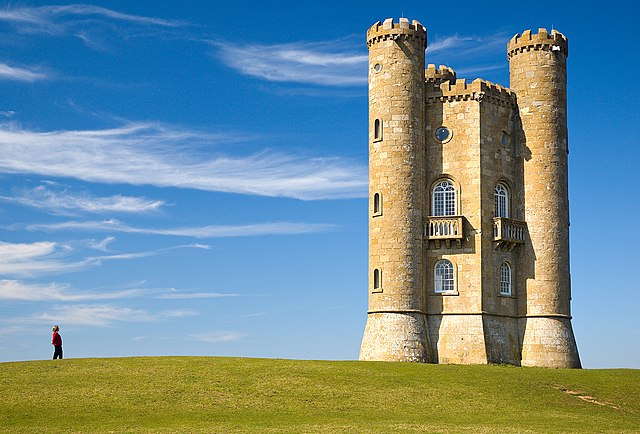

In [ ]:
show_pnm('./in.pnm')

Image size (width x height): 540 x 434


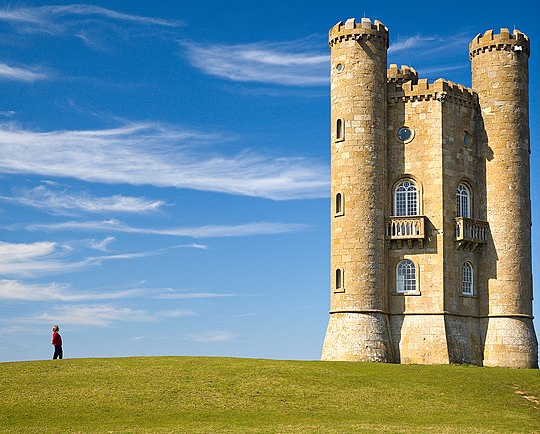

In [6]:
show_pnm('./v1_host_out.pnm')


**2.2. Nhân xét**

- Ảnh thu được sau khi thực thi thí nghiệm đúng với yêu cầu thuật toán, ảnh được thu nhỏ, không  gây biến dạng chủ thể.
- Tuy nhiên thời gian thực thi mất nhiều thời gian. Do đó việc song song hóa chương trình là điều cần thiết.




## IV. Cài đặt song song


### 1. Phân tích

Nhóm sẽ song song hóa các bước sau:

- **Bước 2. Chuyển đổi từ RGB sang Ảnh xám**
- **Bước 3. Tính toán mức độ quan trọng của từng pixel**
- **Bước 4. Tính ma trận chi phí theo chiều dọc**
- **Bước 6. Xóa Seam nhỏ nhất**

Lý do: 

- Chương trình làm việc với dữ liệu lớn (xử lý hình ảnh). 

- Thuật toán seam carving được thiết kế để thực hiện song song trên nhiều dữ liệu đồng thời. Sử dụng CUDA giúp tận dụng hiệu suất tính toán song song của GPU để xử lý dữ liệu lớn nhanh chóng và hiệu quả.

- Cần tăng tốc độ xử lý của chương trình. CUDA cho phép bạn tận dụng GPU để thực hiện các tác vụ tính toán phức tạp, giúp giảm thời gian chạy và tăng tốc độ xử lý so với việc sử dụng CPU truyền thống.


### 2. Thiết kế

- **Bước 2. Chuyển đổi từ RGB sang Ảnh xám:** Dùng block & grid hai chiều, với mỗi thread sẽ xử lí một pixel duy nhất trong ma trận ảnh, với số lượng thread bằng số lượng pixel trong ảnh.
  1. Lặp qua từng pixel trong ảnh:
    - Đối với mỗi pixel, ta lấy giá trị của các thành phần màu (red, green, blue).
    - Áp dụng công thức chuyển đổi màu xám:
      > Y = 0.299R + 0.587G + 0.114B
    - Kết quả của phép tính sẽ là giá trị pixel mới, được lưu vào ảnh đầu ra.
  2. Khi đã xử lí qua tất cả các pixel trong ảnh, quá trình chuyển đổi từ RGB sang xám hoàn thành. Ảnh đầu ra sẽ là ảnh xám với mỗi pixel có giá trị duy nhất đại diện cho mức xám tương ứng.


- **Bước 3. Tính toán mức độ quan trọng của từng pixel:** Một bộ lọc edge detection, chẳng hạn như Sobel filter, được áp dụng lên từng pixel trong ảnh để tính toán độ quan trọng của pixel đó.Dùng block & grid hai chiều với mỗi thread sẽ tính toán energy cho một pixel trong ảnh (grayscale):
  1. Với mỗi pixel, ta xác định vị trí hàng và cột của nó trong ma trận ảnh.
  2. Dùng bộ lọc edge detection, ta tính toán độ quan trọng (importancy) của pixel đó. Quá trình tính toán bao gồm:
  Lặp qua từng phần tử trong bộ lọc:
    - Lấy giá trị filterX và filterY tương ứng với vị trí hiện tại trong bộ lọc.
    - Xác định vị trí của pixel xung quanh pixel đang xét bằng cách trừ đi một nửa chiều rộng của bộ lọc từ vị trí hàng và cột của pixel hiện tại.
    - Kiểm tra xem vị trí hàng và cột của pixel xung quanh có nằm trong phạm vi hợp lệ của ảnh hay không. Nếu nằm ngoài, ta đặt giá trị pixel xung quanh là giá trị pixel gần nhất trong phạm vi ảnh.
    - Lấy giá trị pixel xung quanh và nhân với giá trị filter tương ứng, sau đó cộng vào biến importancy_X và importancy_Y.
  3. Tính toán năng lượng (energy) của pixel đó bằng tổng giá trị tuyệt đối của importancy_X và importancy_Y.
  4. Gán giá trị năng lượng đã tính vào mảng energy tương ứng với vị trí hàng và cột của pixel trong ảnh.

- **Bước 4. Tính ma trận chi phí theo chiều dọc:** 
  1. Với mỗi pixel trong ma trận năng lượng:
    - Xác định vị trí của pixel đó trong ma trận bằng cách sử dụng chỉ số của thread và block.
    - Kiểm tra xem vị trí pixel có nằm trong phạm vi chiều rộng của ảnh không.
Nếu nằm trong phạm vi, tiến hành tính toán chi phí dọc cho pixel đó.
  2. Bắt đầu từ hàng thứ hai (height-2) đến hàng đầu tiên (0):
    - Khởi tạo một biến `min` để lưu giá trị chỉ số của pixel có chi phí thấp nhất trong hàng tiếp theo (hàng r+1).
    - So sánh giá trị năng lượng của pixel hiện tại và hai pixel xung quanh (bên trái và bên phải) của hàng tiếp theo.
    - Nếu pixel bên trái hoặc bên phải có giá trị năng lượng nhỏ hơn pixel `min`, ta gán `min` bằng chỉ số của pixel đó.
Cộng giá trị năng lượng của pixel `min` với giá trị năng lượng của pixel hiện tại.
    - Đồng bộ hóa các thread để đảm bảo rằng toàn bộ các phép tính đã hoàn thành trước khi tiếp tục với hàng tiếp theo.
  3. Quá trình trên được thực hiện cho từng pixel trong ma trận năng lượng. Kết quả là ma trận năng lượng được cập nhật với giá trị chi phí dọc cho mỗi pixel.

- **Bước 6. Xóa Seam nhỏ nhất:** Ta xóa một đường seam từ ma trận ảnh bằng cách loại bỏ các pixel trên đường seam. Sử dụng grid & block hai chiều, với mỗi thread sẽ xử lý một pixel trong ma trận ảnh:
  1. Xác định vị trí hàng i và cột j của pixel đó trong ma trận bằng cách sử dụng chỉ số của thread và block.
    - Kiểm tra xem vị trí pixel có nằm trong phạm vi chiều rộng và chiều cao của ảnh không.
    - Nếu nằm trong phạm vi, tiến hành quá trình xóa đường cắt cho pixel đó.
  2. Lặp qua các chỉ số từ 0 đến `(height-1)`:
    - Kiểm tra nếu pixel hiện tại `(j + i * width)` nằm giữa vùng bị cắt. Sử dụng điều kiện `j + i * width >= next_pixels_v[idx] - idx và j + i * width < next_pixels_v[idx+1] - idx - 1 và idx < height - 1` để xác định vùng bị cắt và đảm bảo idx không bị vượt quá kích thước của height-1
    - .Kiểm tra nếu pixel hiện tại `(j + i * width)` đáp ứng phù hợp điều kiện `j + i * width >= next_pixels_v[idx] - idx && idx == height-1`. Điều kiện này giúp xử lý các pixel còn lại nằm ở dòng height-1 copy dữ liệu từ input vào output tương ứng mà trường hợp ở trên còn thiếu.
    - Kiểm tra điều kiện `j + i * width < next_pixels_v[0]` này để copy lại những pixel không nằm trong vùng dịch chuyển.
    - Sao chép giá trị pixel từ pixel tiếp theo trong ma trận gốc (`inPixels`) vào pixel kết quả (`outPixels`).
Quá trình trên được thực hiện cho từng pixel trong ma trận ảnh. Kết quả là một ma trận ảnh mới (`outPixels`) đã bị cắt đi một đường cắt.

### 3. Đánh giá

- Đầu vào vẫn là ảnh có kích thước 640x434 và ảnh đầu ra có chiều rộng giảm đi 100px (540px). 
- Ta sẽ lấy kết quả của khi thực hiện tuần tự làm chuẩn để so sánh với kết quả thực hiện song song.

In [7]:
!nvcc -arch=sm_{major}{minor} seamCarving_V1.cu -o  seamCarving_V1 --disable-warnings

In [8]:
!./seamCarving_V1 in.pnm kernel 32 32 100

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835398144 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 640 x 434
Kernel time: 
387.136505 ms


Image size (width x height): 540 x 434


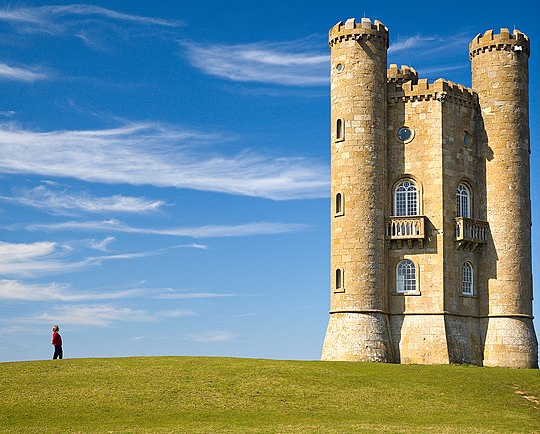

In [9]:
show_pnm("./v1_device_out.pnm")

### Nhận xét:

- Ảnh đầu ra của khi thực hiện song song hoàn toàn trùng khớp với ảnh đầu ra khi thực hiện tuần tự.



## IV. Phiên bản tối ưu 1.


### 1. Phân tích

Nhóm sẽ tối ưu hóa hàm edgeDetectionKernel:
- Sử dụng share memory để copy dữ liệu từ input thay cho việc sử dụng trực tiếp input từ global memory.
- Sử dụng contant memory cho filter thay cho việc sử dụng global memory.

Lý do: 

- Ta sẽ sử dụng share memory trên input để tăng tốc độ truy cập.
- Dùng contant memory cho filter vì filter chỉ dùng để đọc dữ liệu tính toán chứ không cần phải ghi dữ liệu vào, vì vậy dùng contant memory để tăng tốc truy cập vùng nhớ.


### 2. Thiết kế

- **Bước 1. Khởi tạo ra một mảng share memory và cấp phát vùng nhớ** 
- **Bước 2. Tính toán vị trí của share memory của block tương ứng với vị trí cần copy.**
- **Bước 3. Sau khi đã tính toán được vị trí tương ứng của share memory với vị trí của mảng input, ta tiến hành copy dữ liệu từ mảng input sang share memory.**
- **Bước 4. Sau khi đã copy xong xử liệu cho share memory ta tiến hành tính toán tích chập trên filter từ share memory và lưu và vị trí tương ứng của mảng output.**

### 3. Đánh giá

- Đầu vào vẫn là ảnh có kích thước 640x434 và ảnh đầu ra có chiều rộng giảm đi 100px (540px). 
- Ta sẽ lấy kết quả của khi thực hiện tuần tự làm chuẩn để so sánh với kết quả thực hiện song song.

In [10]:
!nvcc -arch=sm_{major}{minor} seamCarving_V2.cu -o  seamCarving_V2 --disable-warnings

In [12]:
!./seamCarving_V2 in.pnm kernel 32 32 100

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835398144 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 640 x 434
Kernel time: 
349.110199 ms


Image size (width x height): 540 x 434


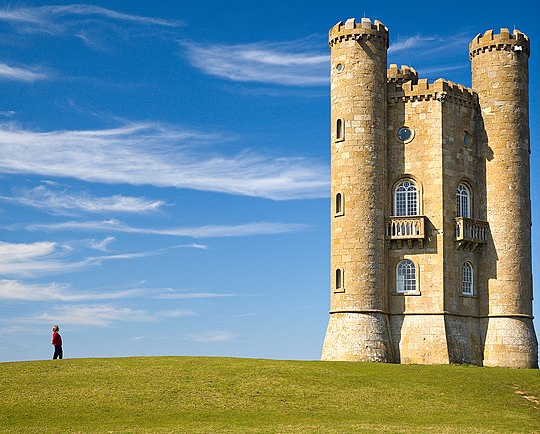

In [13]:
show_pnm("./v2_device_out.pnm")

## IV. Phiên bản tối ưu 2.


### 1. Phân tích

Nhóm sẽ tối ưu hóa hàm removeSeamKernel từ phiên bản tối ưu trước:
- Duyệt vòng lặp từ vị trí i-1 cho đến i+3, thay vì duyệt từ 0 cho đến height-2 cho mỗi lần lặp.
- Bỏ điều kiện kiểm tra vị trí của những pixel không cần dời vị trí ra khỏi vòng lặp.

Lý do: 

- Vì để tính ra vị trí cần xóa và vị trí dừng của mảng ta chỉ cần duyệt qua vị trí trước nó và sau nó 3 đơn vị là đã đủ.
- còn phẩn bỏ điều kiện để tìm vị trí của những pixel không cần dời vị trí ta chỉ cần kiểm tra 1 lần là được không cần chạy trong vòng lặp lại nhiều lần.


### 2. Thiết kế

- **Bước 1. Xác định vị trí của mảng cần xóa** 
- **Bước 2. Kiểm tra xem vị trí cần xóa có nhỏ hơn vị trí của đường seam ở trị ví 0 hay không nếu có thì copy lại vị trí đó từ inpixels qua oupixels**
- **Bước 3. xác định vị trí của seam cần xóa trên từng dòng**
- **Bước 4. Xóa và cập nhật lại vị trí tương ứng.**

### 3. Đánh giá

- Đầu vào vẫn là ảnh có kích thước 640x434 và ảnh đầu ra có chiều rộng giảm đi 100px (540px). 
- Ta sẽ lấy kết quả của khi thực hiện tuần tự làm chuẩn để so sánh với kết quả thực hiện song song.

In [15]:
!nvcc -arch=sm_{major}{minor} seamCarving_V3.cu -o  seamCarving_V3 --disable-warnings

In [17]:
!./seamCarving_V3 in.pnm kernel 32 32 100

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835398144 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 640 x 434
Kernel time: 
153.699738 ms


Image size (width x height): 540 x 434


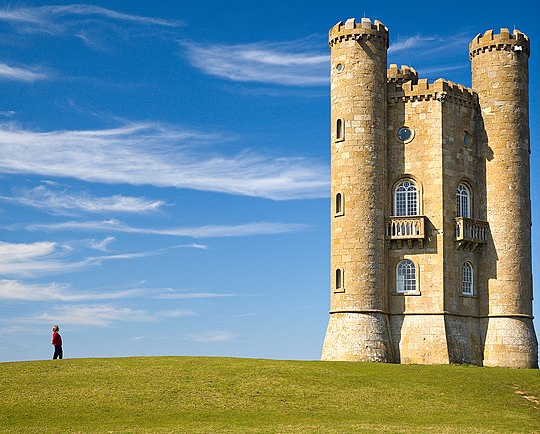

In [18]:
show_pnm("./v3_device_out.pnm")

## V. Nhìn lại quá trình làm đồ án.
- **Thuận lợi**: Có thể tham khảo trên Internet dễ dàng. 
- **Khó khăn**: Chưa thể tìm hiểu hết các kiến thức chuyên sâu. 
- Qua đồ án này nhóm em học được các kiến thức: Biết thêm về thuật toán Seam Carving, cách mà các thread hoạt động chạy song song, hiểu về các loại bộ nhớ contant, share, global, register và cách để dùng từng loại bộ nhớ để tối ưu đồ án. các bước phân tích và thiết kế để song song hóa một bài toán cụ thể


##VI. **Cải thiện bài toán**
Ứng dụng việc thay đổi kích thước ảnh bằng cách sử dụng "Seam Carving" ít nhiều khi thực hiện lượt bỏ đi một số lượng đáng kể nhiều seam thì ảnh bị bóp mèo là không tránh khỏi. 

Nhóm sẽ tìm hiểu để sau khi thực hiện việc thay đổi kích thước này ảnh sẽ mất mát dữ liệu là ít nhất

## VII. TÀI LIỆU THAM KHẢO

*   https://github.com/hoangquan001/SeamCarving-CUDA-C/blob/master/Seam_Carving.ipynb
*   https://github.com/pdthuc/CUDA_Seam-Carving/blob/main/v2_seamCarving.cu
* Seam carving: https://en.wikipedia.org/wiki/Seam_carving

